In [1]:
import pandas as pd

# Load the uploaded CSV files to check their structure and contents
file_path_projections = "C:/Users/PC/desktop/바탕 화면/archive/indiana_projections.csv"
file_path_reports ="C:/Users/PC/desktop/바탕 화면/archive/indiana_reports.csv"


# Read the CSV files
data_projections = pd.read_csv(file_path_projections)
data_reports = pd.read_csv(file_path_reports)
# Filter for "Frontal" images in the projections dataset
frontal_data = data_projections[data_projections['projection'] == 'Frontal']

# Merge the frontal data with the reports data using 'uid' as the key
merged_data = pd.merge(frontal_data, data_reports, on='uid', how='inner')

# Check the resulting merged data
merged_data.head()


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,5_IM-2117-1003002.dcm.png,Frontal,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [2]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from torch.utils.data import DataLoader, Dataset
# findings와 impression 결합
merged_data["report"] = merged_data["findings"].fillna("") + " " + merged_data["impression"].fillna("")
merged_data["report"] = merged_data["report"].str.strip()

# 필요한 컬럼 선택 및 NaN 제거
merged_data = merged_data[["uid", "filename", "projection", "indication", "report"]].dropna()

# BERT Tokenizer 로드 (BioBERT로 변경)
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# MLM 데이터셋 클래스 정의
class MLM_Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # BERT 토크나이징
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [3]:
from transformers import BertForSequenceClassification

# 모델 로드 (BioBERT로 변경)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)

# 데이터셋 및 DataLoader 생성
mlm_dataset = MLM_Dataset(merged_data["report"].tolist() + merged_data["indication"].tolist(), tokenizer)
mlm_dataloader = DataLoader(mlm_dataset, batch_size=8, shuffle=True)


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
import random
import torch

# 'report' 컬럼에서 'XXXX' 제외한 텍스트를 필터링
filtered_texts = [text for text in merged_data["report"].dropna() if "XXXX" not in text]

# 랜덤 샘플 선택 (filtered_texts가 비어 있으면 기본값 제공)
sample_text = random.choice(filtered_texts) if filtered_texts else "No valid text found."

# 텍스트에서 'XXXX' 제외한 단어들만 선택
words = sample_text.split()
candidate_indices = [i for i, word in enumerate(words) if word != "XXXX" and "." not in word and "," not in word]

# 랜덤으로 3개의 단어 마스킹
mask_count = min(3, len(candidate_indices))  # 최소 3개 단어 마스킹, 후보 단어가 3개 미만이면 그 수만큼 마스크
mask_indices = random.sample(candidate_indices, mask_count)

# 마스킹 수행
masked_text = words[:]
for idx in mask_indices:
    masked_text[idx] = tokenizer.mask_token  # [MASK] 토큰 적용

masked_text = " ".join(masked_text)

# 토크나이징 및 텐서 변환
inputs = tokenizer(masked_text, return_tensors="pt").to(device)
mask_idx = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

# MLM 예측 수행
with torch.no_grad():
    predictions = model(**inputs).logits

# 실제 단어 인덱스 추출
actual_words = [words[i] for i in mask_indices]

# 마스크된 토큰 예측 및 복원
predicted_text = masked_text
correct_predictions = 0
for idx, mask_position in enumerate(mask_idx.tolist()):
    predicted_token = tokenizer.decode(torch.argmax(predictions[0, mask_position]).item()).strip()  # 예측된 토큰
    actual_word = actual_words[idx].strip()  # 실제 단어
    
    # 대소문자 무시하고 비교
    if predicted_token.lower() == actual_word.lower():
        correct_predictions += 1

    # 원래 대소문자를 유지한 채 예측된 단어로 텍스트 업데이트
    predicted_text = predicted_text.replace(tokenizer.mask_token, predicted_token, 1)

# 정확도 계산
accuracy = (correct_predictions / mask_count) * 100 if mask_count > 0 else 0

# 결과 출력
print("=" * 50)
print("📝 원본 텍스트:\n", sample_text, "\n", "=" * 50)
print("\n🔍 마스킹된 텍스트:\n", masked_text, "\n", "=" * 50)
print("\n🎯 예측된 텍스트:\n", predicted_text, "\n", "=" * 50)
print(f"\n✅ 정확도: {accuracy:.2f}% ({correct_predictions}/{mask_count}개 맞춤)")


📝 원본 텍스트:
 The heart size is top normal, cardiomediastinal silhouette within normal limits. Pulmonary vasculature appears normal. There is no focal air space consolidation. No pleural effusion or pneumothorax. 

🔍 마스킹된 텍스트:
 The [MASK] size is top normal, [MASK] silhouette within normal limits. Pulmonary vasculature appears normal. There is [MASK] focal air space consolidation. No pleural effusion or pneumothorax. 

🎯 예측된 텍스트:
 The heart size is top normal, cardiac silhouette within normal limits. Pulmonary vasculature appears normal. There is no focal air space consolidation. No pleural effusion or pneumothorax. 

✅ 정확도: 33.33% (1/3개 맞춤)



Epoch 1/5 훈련 중...
  10/1614 샘플 처리됨... 훈련 손실: 0.4268
  30/1614 샘플 처리됨... 훈련 손실: 0.4081
  20/1614 샘플 처리됨... 훈련 손실: 0.3772
  20/1614 샘플 처리됨... 훈련 손실: 0.6713
  10/1614 샘플 처리됨... 훈련 손실: 0.6807
  10/1614 샘플 처리됨... 훈련 손실: 0.4740
  20/1614 샘플 처리됨... 훈련 손실: 0.6758
  30/1614 샘플 처리됨... 훈련 손실: 0.8346
  10/1614 샘플 처리됨... 훈련 손실: 0.5477
  10/1614 샘플 처리됨... 훈련 손실: 0.5798
  10/1614 샘플 처리됨... 훈련 손실: 0.4119
  20/1614 샘플 처리됨... 훈련 손실: 0.7682
  10/1614 샘플 처리됨... 훈련 손실: 0.9492
  10/1614 샘플 처리됨... 훈련 손실: 0.4347
  10/1614 샘플 처리됨... 훈련 손실: 1.1402
  30/1614 샘플 처리됨... 훈련 손실: 0.4145
  10/1614 샘플 처리됨... 훈련 손실: 0.9150
  30/1614 샘플 처리됨... 훈련 손실: 0.4246
  10/1614 샘플 처리됨... 훈련 손실: 0.5503
  10/1614 샘플 처리됨... 훈련 손실: 0.7128
  10/1614 샘플 처리됨... 훈련 손실: 0.7682
  10/1614 샘플 처리됨... 훈련 손실: 0.8486
  50/1614 샘플 처리됨... 훈련 손실: 0.3697
  30/1614 샘플 처리됨... 훈련 손실: 0.8056
  60/1614 샘플 처리됨... 훈련 손실: 0.2454
  10/1614 샘플 처리됨... 훈련 손실: 0.6182
  10/1614 샘플 처리됨... 훈련 손실: 0.5379
  20/1614 샘플 처리됨... 훈련 손실: 0.6288
  30/1614 샘플 처리됨... 훈련 손실: 0.

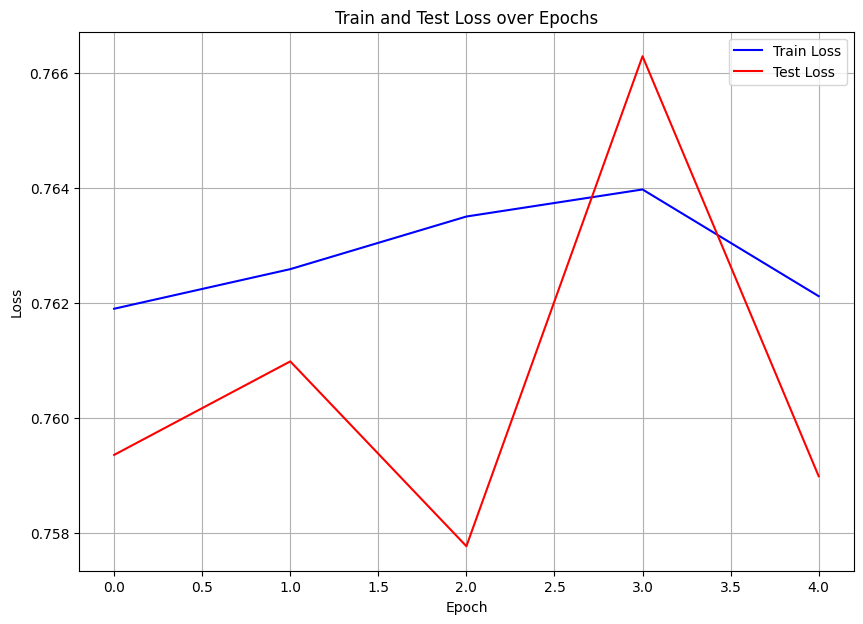

In [13]:
import random
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# 'report' 컬럼에서 'XXXX' 제외한 텍스트를 필터링
filtered_texts = [text for text in merged_data["report"].dropna() if "XXXX" not in text]

# 훈련 데이터와 테스트 데이터 분리 (80% 훈련, 20% 테스트)
train_texts, test_texts = train_test_split(filtered_texts, test_size=0.2, random_state=42)

# 손실을 기록할 리스트
train_losses = []
test_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_EPOCHS = 5  # 에폭을 5로 설정

# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()  # 훈련 모드 활성화
    epoch_train_losses = []

    print(f"\nEpoch {epoch + 1}/{N_EPOCHS} 훈련 중...")

    # 훈련 데이터로 훈련
    for idx, sample_text in enumerate(train_texts):
        # 텍스트에서 'XXXX' 제외한 단어들만 선택
        words = sample_text.split()
        candidate_indices = [i for i, word in enumerate(words) if word != "XXXX" and "." not in word and "," not in word]

        # 랜덤으로 15% 단어 마스킹
        mask_count = max(1, int(len(candidate_indices) * 0.15))  
        mask_indices = random.sample(candidate_indices, mask_count)

        # 마스킹 수행
        masked_text = words[:]
        for idx in mask_indices:
            masked_text[idx] = tokenizer.mask_token  # [MASK] 토큰 적용
        masked_text = " ".join(masked_text)

        # 토크나이징 및 텐서 변환
        inputs = tokenizer(masked_text, return_tensors="pt").to(device)
        labels = inputs.input_ids.clone()
        labels[inputs.input_ids == tokenizer.mask_token_id] = -100  # 마스크된 부분은 -100으로 설정

        # 모델 예측
        outputs = model(**inputs)
        predictions = outputs.logits

        # loss 계산
        loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), labels.view(-1), ignore_index=-100)
        epoch_train_losses.append(loss.item())

        # 10개마다 진행 상황 출력
        if (idx + 1) % 10 == 0:
            print(f"  {idx + 1}/{len(train_texts)} 샘플 처리됨... 훈련 손실: {loss.item():.4f}")

    # 훈련 손실 평균 계산
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)
    print(f"훈련 손실 (에폭 {epoch + 1}): {avg_train_loss:.4f}")

    # 평가
    model.eval()  # 평가 모드 활성화
    epoch_test_losses = []

    with torch.no_grad():  # 평가 시 그래디언트 계산 안함
        print(f"\n평가 중... (에폭 {epoch + 1}/{N_EPOCHS})")
        for idx, sample_text in enumerate(test_texts):
            # 텍스트에서 'XXXX' 제외한 단어들만 선택
            words = sample_text.split()
            candidate_indices = [i for i, word in enumerate(words) if word != "XXXX" and "." not in word and "," not in word]

            # 랜덤으로 15% 단어 마스킹
            mask_count = max(1, int(len(candidate_indices) * 0.15))  
            mask_indices = random.sample(candidate_indices, mask_count)

            # 마스킹 수행
            masked_text = words[:]
            for idx in mask_indices:
                masked_text[idx] = tokenizer.mask_token  # [MASK] 토큰 적용
            masked_text = " ".join(masked_text)

            # 토크나이징 및 텐서 변환
            inputs = tokenizer(masked_text, return_tensors="pt").to(device)
            labels = inputs.input_ids.clone()
            labels[inputs.input_ids == tokenizer.mask_token_id] = -100  # 마스크된 부분은 -100으로 설정

            # 모델 예측
            outputs = model(**inputs)
            predictions = outputs.logits

            # loss 계산
            loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), labels.view(-1), ignore_index=-100)
            epoch_test_losses.append(loss.item())

            # 10개마다 평가 진행 상황 출력
            if (idx + 1) % 10 == 0:
                print(f"  {idx + 1}/{len(test_texts)} 샘플 처리됨... 평가 손실: {loss.item():.4f}")

    # 평가 손실 평균 계산
    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)
    print(f"평가 손실 (에폭 {epoch + 1}): {avg_test_loss:.4f}")

# 훈련과 평가 손실 그래프 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss', color='blue')
plt.plot(range(N_EPOCHS), test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
